<a href="https://colab.research.google.com/github/villasen/colab_notebooks/blob/master/6words_full_integer_quantization_ESC50_splitted_16KHz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/villasen/Sound-Datasets.git
!rm -r sample_data

Cloning into 'Sound-Datasets'...
remote: Enumerating objects: 49500, done.
remote: Total 49500 (delta 0), reused 0 (delta 0), pack-reused 49500
Receiving objects: 100% (49500/49500), 1.97 GiB | 35.97 MiB/s, done.
Resolving deltas: 100% (15354/15354), done.
Checking out files: 100% (53687/53687), done.


In [0]:
MFCC=14

In [3]:
import keras
from keras import layers
from keras import models
from keras import backend as K
from keras import optimizers
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import numpy as np
import librosa
import tensorflow
import scipy
import os, shutil
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from six.moves import urllib
import sys
import tarfile
import os.path
from os import path
from tensorflow.python.ops import io_ops
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from numpy  import array
from tensorflow.contrib.quantize.python import fold_batch_norms
from tensorflow.contrib.quantize.python import quantize
from tensorflow.python.framework import ops
print(tf.__version__)






########### FUNCTIONS

def urban_wav2mfcc(file_path, max_pad_len):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=MFCC, n_fft=640, hop_length=320)
      
    pad_width = max_pad_len - mfcc.shape[1]
    #print(max_pad_len)
    #print(mfcc.shape[1])
    #print(pad_width)
    if pad_width < 0: 
      print(mfcc.shape[1])
      print(pad_width)
      print("error in "+ file_path)
    
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc 


  
  
def load_wav_file(wav_file):
  with tf.Session(graph=tf.Graph()) as sess:
      wav_filename_placeholder = tf.placeholder(tf.string, [])
      wav_loader = io_ops.read_file(wav_filename_placeholder)
      wav_decoder = contrib_audio.decode_wav(wav_loader, desired_channels=1)
      return sess.run(
          wav_decoder,
          feed_dict={wav_filename_placeholder: wav_file}).audio.flatten()










Using TensorFlow backend.


1.15.0-rc3


In [0]:
!pip install --upgrade tensorflow-gpu
# Installing tf version 1.15
! pip uninstall -y tensorflow
#! pip install -U tf-nightly
!pip install tf-nightly==1.15.0.dev20190821
!rm -rf /tmp/urban_sound_models


In [0]:
def build_urban_model():
 return keras.Sequential([
      
    keras.layers.Conv2D(64, (4,MFCC), strides=(2,2), padding='same', activation='relu', input_shape=(MFCC,51,1), kernel_regularizer=keras.regularizers.l2(0.001)),     

# Depthwise layers
    keras.layers.Dropout(0.5), 
    keras.layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),

      
    keras.layers.AveragePooling2D(pool_size=(5, 25), strides=(2,2), padding='valid', data_format=None),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(data_format=None),
    keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001),  activation='relu'),
  
      
    keras.layers.Dense(6, activation='softmax')     
      
      
  ])  


In [5]:
import tensorflow as tf
tf.enable_eager_execution()
import os.path
from os import path

#!rm -r _background_noise_

MFCC=14

DATA_PATH= '/content/Sound-Datasets/downsampled_ESC-50_splitted_data_set/'
!ls -al /content/Sound-Datasets/downsampled_ESC-50_splitted_data_set/


labels = os.listdir('Sound-Datasets/downsampled_ESC-50_splitted_data_set/')
print(labels)

test_single_file = '/content/test_single_file/'
if path.exists('/content/test_single_file/') :
    print ("folder test_single exits, removing")
    !rm -rf /content/test_single_file
os.mkdir(test_single_file)

target_npy_files = "/content/target_npy_files/"
if path.exists("/content/target_npy_files/") :
    print ("folder target_npy_files exits, removing")
    !rm -rf /content/target_npy_files
os.mkdir(target_npy_files)


target_txt_files = "/content/target_txt_files/"
if path.exists("/content/target_txt_files/") :
    print ("folder target_txt_files folder exits, removing")
    !rm -rf /content/target_txt_files
os.mkdir(target_txt_files)



#crying baby
# if path.exists("/content/test_single_file/crying_baby") :
#      print ("folder test_single_file/crying_baby exits, removing")
#      !rm -rf /content/test_single_file/crying_baby
# os.mkdir('/content/test_single_file/crying_baby')

# dog
if path.exists("/content/test_single_file/dog") :
     print ("folder test_single_file/dog exits, removing")
     !rm -rf /content/test_single_file/dog
os.mkdir('/content/test_single_file/dog')



# clapping
if path.exists("/content/test_single_file/clapping") :
     print ("folder test_single_file/clapping exits, removing")
     !rm -rf /content/test_single_file/clapping
os.mkdir('/content/test_single_file/clapping')

# door knock
if path.exists("/content/test_single_file/door_knock") :
    print ("folder test_single_file/door_knock exits, removing")
    !rm -rf /content/test_single_file/door_knock
os.mkdir('/content/test_single_file/door_knock')

# clock alarm
if path.exists("/content/test_single_file/clock_alarm") :
    print ("folder test_single_file/clock_alarm exits, removing")
    !rm -rf /content/test_single_file/clock_alarm
os.mkdir('/content/test_single_file/clock_alarm')

# glass_breaking
if path.exists("/content/test_single_file/glass_breaking") :
    print ("folder test_single_file/glass_breaking exits, removing")
    !rm -rf /content/test_single_file/glass_breaking
os.mkdir('/content/test_single_file/glass_breaking')

# fireworks
if path.exists("/content/test_single_file/fireworks") :
    print ("folder test_single_file/fireworks exits, removing")
    !rm -rf /content/test_single_file/fireworks
os.mkdir('/content/test_single_file/fireworks')

total 608
drwxr-xr-x 52 root root  4096 Oct 17 02:32 .
drwxr-xr-x 13 root root  4096 Oct 17 02:33 ..
drwxr-xr-x  2 root root 12288 Oct 17 02:32 airplane
drwxr-xr-x  2 root root 12288 Oct 17 02:32 breathing
drwxr-xr-x  2 root root 12288 Oct 17 02:32 brushing_teeth
drwxr-xr-x  2 root root 12288 Oct 17 02:32 can_opening
drwxr-xr-x  2 root root 12288 Oct 17 02:32 car_horn
drwxr-xr-x  2 root root 12288 Oct 17 02:32 cat
drwxr-xr-x  2 root root 12288 Oct 17 02:32 chainsaw
drwxr-xr-x  2 root root 12288 Oct 17 02:32 chirping_birds
drwxr-xr-x  2 root root 12288 Oct 17 02:32 church_bells
drwxr-xr-x  2 root root 12288 Oct 17 02:32 clapping
drwxr-xr-x  2 root root 12288 Oct 17 02:32 clock_alarm
drwxr-xr-x  2 root root 12288 Oct 17 02:32 clock_tick
drwxr-xr-x  2 root root 12288 Oct 17 02:32 coughing
drwxr-xr-x  2 root root 12288 Oct 17 02:32 cow
drwxr-xr-x  2 root root 12288 Oct 17 02:32 crackling_fire
drwxr-xr-x  2 root root 12288 Oct 17 02:32 crickets
drwxr-xr-x  2 root root 12288 Oct 17 02:32 cro

### Test sample 1

In [7]:

!mv  /content/Sound-Datasets/downsampled_ESC-50_splitted_data_set/crying_baby/A-5-198411-D.wav  /content/test_single_file/crying_baby/
!mv  /content/Sound-Datasets/downsampled_ESC-50_splitted_data_set/clapping/A-1-105224-A.wav  /content/test_single_file/clapping/
!mv  /content/Sound-Datasets/downsampled_ESC-50_splitted_data_set/dog/A-1-97392-A.wav  /content/test_single_file/dog/
!mv  /content/Sound-Datasets/downsampled_ESC-50_splitted_data_set/door_knock/A-1-101336-A.wav  /content/test_single_file/door_knock/
!mv  /content/Sound-Datasets/downsampled_ESC-50_splitted_data_set/clock_alarm/A-5-210612-A.wav  /content/test_single_file/clock_alarm/
!mv  /content/Sound-Datasets/downsampled_ESC-50_splitted_data_set/glass_breaking/A-1-84705-A.wav  /content/test_single_file/glass_breaking/
!mv  /content/Sound-Datasets/downsampled_ESC-50_splitted_data_set/fireworks/A-1-160563-A.wav  /content/test_single_file/fireworks/

mv: cannot move '/content/Sound-Datasets/downsampled_ESC-50_splitted_data_set/crying_baby/A-5-198411-D.wav' to '/content/test_single_file/crying_baby/': Not a directory


### Test sample 2

In [0]:
!cp -r /content/Sound-Datasets/downsampled_ESC-50_splitted_data_set/crying_baby/C-1-187207-A.wav  /content/test_single_file/crying_baby/
!cp -r /content/Sound-Datasets/downsampled_ESC-50_splitted_data_set/clapping/E-5-221950-A.wav  /content/test_single_file/clapping/
!cp -r /content/Sound-Datasets/downsampled_ESC-50_splitted_data_set/door_knock/D-5-250026-B.wav  /content/test_single_file/door_knock/
!cp -r /content/Sound-Datasets/downsampled_ESC-50_splitted_data_set/clock_alarm/A-3-117793-A.wav  /content/test_single_file/clock_alarm/
!cp -r /content/Sound-Datasets/downsampled_ESC-50_splitted_data_set/glass_breaking/D-3-216280-A.wav  /content/test_single_file/glass_breaking/
!cp -r /content/Sound-Datasets/downsampled_ESC-50_splitted_data_set/fireworks/E-5-160614-B.wav  /content/test_single_file/fireworks/
!cp -r /content/Sound-Datasets/downsampled_ESC-50_splitted_data_set/dog/C-5-203128-B.wav  /content/test_single_file/dog/

In [8]:
path = DATA_PATH
labels = os.listdir(path) 
print(labels)

max_feature = 0
for label in labels:
  mfcc_vectors=[]
   
  wavefiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
    
  if label=='dog' or label=='clapping' or label=='door_knock' or label=='clock_alarm' \
             or label=='glass_breaking' or label=='fireworks': 
#  if label=='clapping': 
    for wavfile in wavefiles:
            
      max_pad_len = 51
      #mfcc = urban_wav2mfcc(wavfile, 51)
      wave, sr = librosa.load(wavfile , mono=True, sr=None)
      #mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=10, n_fft=3200, hop_length=1600)
      mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=MFCC, n_fft=640, hop_length=320)
      #print(mfcc)
      pad_width = max_pad_len - mfcc.shape[1]
      #print(max_pad_len)
      #print(mfcc.shape[1])
      #print(pad_width)
      
      if pad_width < 0: 
        print(mfcc.shape[1])
        print(pad_width)
        #print("error in "+ file_path)
      mfcc_vectors.append(mfcc)


    np.save('/content/target_npy_files/' + label + '.npy', mfcc_vectors)
    np.savetxt('/content/target_txt_files/' + label + '.txt', mfcc_vectors[2], delimiter=', ')
    print(label)

['door_wood_creacks', 'chirping_birds', 'insects', 'sea_waves', 'clock_alarm', 'chainsaw', 'siren', 'frog', 'clapping', 'cow', 'rooster', 'drinking_sipping', 'clock_tick', 'can_opening', 'train', 'crickets', 'washing_machine', 'sheep', 'hen', 'thunderstorm', 'breathing', 'glass_breaking', 'water_drops', 'crackling_fire', 'engine', 'handsaw', 'brushing_teeth', 'laughing', 'car_horn', 'pouring_water', 'sneezing', 'wind', 'cat', 'airplane', 'crow', 'door_knock', 'mouse_click', 'pig', 'fireworks', 'toilet_flush', 'church_bells', 'vacuum_cleaner', 'Helicopter', 'rain', 'snoring', 'keyboard_typing', 'dog', 'crying_baby', 'coughing', 'footsteps']
clock_alarm
clapping
glass_breaking
door_knock
fireworks
dog


In [9]:
split_ratio = 0.8
random_state = 42

npy_files= os.listdir('/content/target_npy_files/')
print(npy_files)

X = np.load('/content/target_npy_files/' + npy_files[0])
y = np.zeros(X.shape[0])
print(npy_files[0])
print(npy_files[1])
print(npy_files[2])
print(X.shape)
print(y.shape)


# # Append all of the dataset into one single array, same goes for 
for i, label in enumerate(npy_files[1:]):
   x = np.load('/content/target_npy_files/' + label)
  
#     #x = np.load('/content/speech-numpy/' + label)

   X = np.vstack((X, x))
   y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))


# return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)


X_train = X_train.reshape(X_train.shape[0], MFCC, 51, 1)
X_test = X_test.reshape(X_test.shape[0], MFCC, 51, 1)
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)





#mfcc_crying_baby = urban_wav2mfcc('test_single_file/crying_baby/A-5-198411-D.wav', max_pad_len=51)
mfcc_dog = urban_wav2mfcc('test_single_file/dog/A-1-97392-A.wav', max_pad_len=51)
mfcc_clapping = urban_wav2mfcc('test_single_file/clapping/A-1-105224-A.wav', max_pad_len=51)
mfcc_door_knock = urban_wav2mfcc('test_single_file/door_knock/A-1-101336-A.wav', max_pad_len=51)
mfcc_clock_alarm = urban_wav2mfcc('test_single_file/clock_alarm/A-5-210612-A.wav', max_pad_len=51)
mfcc_glass_breaking = urban_wav2mfcc('test_single_file/glass_breaking/A-1-84705-A.wav', max_pad_len=51)
mfcc_fireworks = urban_wav2mfcc('test_single_file/fireworks/A-1-160563-A.wav', max_pad_len=51)

#crying_baby_file = mfcc_crying_baby.reshape(1, MFCC, 51, 1)
dog_file = mfcc_dog.reshape(1, MFCC, 51, 1)
clapping_file = mfcc_clapping.reshape(1, MFCC, 51, 1)
door_knock_file = mfcc_door_knock.reshape(1, MFCC, 51, 1)
clock_alarm_file = mfcc_clock_alarm.reshape(1, MFCC, 51, 1)
glass_breaking_file = mfcc_glass_breaking.reshape(1, MFCC, 51, 1)
fireworks_file = mfcc_fireworks.reshape(1, MFCC, 51, 1)

#np.save('/content/' + 'crying_baby_single.npy', crying_baby_file)
np.save('/content/' + 'dog_single.npy', dog_file)
np.save('/content/' + 'clapping_single.npy', clapping_file)
np.save('/content/' + 'door_knock_single.npy', door_knock_file )
np.save('/content/' + 'clock_alarm_single.npy', clock_alarm_file )
np.save('/content/' + 'glass_breaking_single.npy', glass_breaking_file)
np.save('/content/' + 'fireworks_single.npy', fireworks_file)

['door_knock.npy', 'clapping.npy', 'glass_breaking.npy', 'clock_alarm.npy', 'fireworks.npy', 'dog.npy']
door_knock.npy
clapping.npy
glass_breaking.npy
(199, 14, 51)
(199,)


In [10]:
!rm checkpoint
!rm checkpoints.data-00000-of-00001
!rm checkpoints.index
!rm checkpoints.meta


speech_graph = tf.Graph()
speech_sess = tf.Session(graph=speech_graph)

keras.backend.set_session(speech_sess)
with speech_graph.as_default():
     
  #build my model
  model = build_urban_model()
  #give me model structure
  model.summary()

  #my own optimizer
  Amartin = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
  
  model.compile(optimizer= Amartin, loss='categorical_crossentropy', metrics=['accuracy'])
  
  # run it
  history = model.fit(X_train, y_train_hot, batch_size=200, epochs=300, verbose=1, validation_data=(X_test, y_test_hot))
  #save my graph
  saver = tf.train.Saver()
  saver.save(speech_sess, 'checkpoints')

rm: cannot remove 'checkpoint': No such file or directory
rm: cannot remove 'checkpoints.data-00000-of-00001': No such file or directory
rm: cannot remove 'checkpoints.index': No such file or directory
rm: cannot remove 'checkpoints.meta': No such file or directory




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 7, 26, 64)         3648      
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 26, 64)         0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 7, 26, 64)         4736      
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 26, 64)         0        

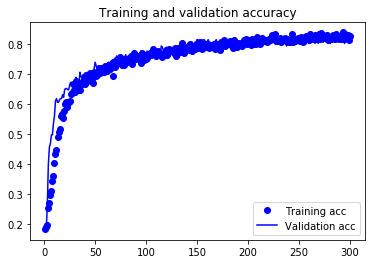

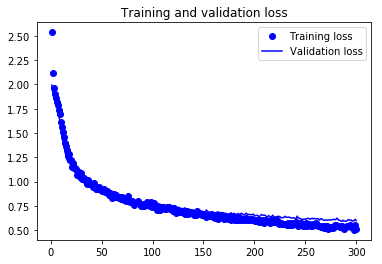

In [11]:
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs,val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

In [12]:
eval_speech_graph = tf.Graph()
eval_speech_sess = tf.Session(graph=eval_speech_graph)

keras.backend.set_session(eval_speech_sess)
with eval_speech_graph.as_default():
    keras.backend.set_learning_phase(0)
    eval_model = build_urban_model()

    #For quantization aware training only
    #tf.contrib.quantize.create_eval_graph(input_graph=eval_speech_graph)
    eval_speech_graph_def = eval_speech_graph.as_graph_def()
    saver = tf.train.Saver()
    saver.restore(eval_speech_sess, 'checkpoints')

    frozen_graph_def = tf.graph_util.convert_variables_to_constants( eval_speech_sess, eval_speech_graph_def, 
                                                                    [eval_model.output.op.name] )

    with open('frozen_urban_model.pb', 'wb') as f:
      f.write(frozen_graph_def.SerializeToString())

INFO:tensorflow:Restoring parameters from checkpoints
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.


In [0]:
import pathlib

tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.DEBUG)

converter = tf.lite.TFLiteConverter.from_frozen_graph( "frozen_urban_model.pb", ["conv2d_1_input"], ["dense_2/Softmax"])
tflite_model = converter.convert()

In [0]:
tflite_models_dir = pathlib.Path("/tmp/ESC50-split-models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [0]:
dog_uint8 = tf.cast(dog_file, tf.uint8)
clapping_uint8 = tf.cast(clapping_file, tf.uint8)
door_knock_uint8 = tf.cast(door_knock_file, tf.uint8)
clock_alarm_uint8 = tf.cast(clock_alarm_file, tf.uint8)
glass_breaking_uint8 = tf.cast(glass_breaking_file, tf.uint8)
fireworks_uint8 = tf.cast(fireworks_file, tf.uint8)


In [0]:
np.save('/content/' + 'dog_single_uint8.npy', dog_uint8)
np.save('/content/' + 'clapping_single_uint8.npy', clapping_uint8)
np.save('/content/' + 'door_knock_single_uint8.npy', door_knock_uint8)
np.save('/content/' + 'clock_alarm_single_uint8.npy', clock_alarm_uint8 )
np.save('/content/' + 'glass_breaking_single_uint8.npy', glass_breaking_uint8)
np.save('/content/' + 'fireworks_single_uint8.npy', fireworks_uint8 )

In [18]:
tflite_model_file = tflite_models_dir/"esc50-split-model.tflite"
tflite_model_file.write_bytes(tflite_model)

87500

In [19]:
!ls -lh {tflite_models_dir}

total 88K
-rw-r--r-- 1 root root 86K Oct 17 02:50 esc50-split-model.tflite


In [0]:
# Optimize for size
tf.logging.set_verbosity(tf.logging.INFO)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [0]:
# Create quantized values with an accurate dynamic range of activations, 
# for that need to provide a representative dataset

#sounds = tf.cast(X_train, tf.float32)/255.0
sounds = tf.cast(X_train, tf.float32)
urban_ds = tf.data.Dataset.from_tensor_slices((sounds)).batch(1)
def representative_data_gen():
  for input_value in urban_ds.take(100):
    yield [input_value]
    
converter.representative_dataset = representative_data_gen

In [22]:
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"esc50-split-model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

31120

In [23]:
!ls -lh {tflite_models_dir}

total 120K
-rw-r--r-- 1 root root 31K Oct 17 02:50 esc50-split-model_quant.tflite
-rw-r--r-- 1 root root 86K Oct 17 02:50 esc50-split-model.tflite


In [24]:
# The converted model needs to be fully quantized. That means all ops need to be 
# quantized, no floats left. The input and outputs need to be integers too.

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()
tflite_model_quant_file = tflite_models_dir/"esc50-split-model_quant_io.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

31192

In [25]:
!ls -lh {tflite_models_dir}

total 152K
-rw-r--r-- 1 root root 31K Oct 17 02:50 esc50-split-model_quant_io.tflite
-rw-r--r-- 1 root root 31K Oct 17 02:50 esc50-split-model_quant.tflite
-rw-r--r-- 1 root root 86K Oct 17 02:50 esc50-split-model.tflite


In [26]:
# Load data for float model
#sounds = tf.cast(X_test, tf.float32)/255.0
sounds = tf.cast(X_test, tf.float32)
urban_ds = tf.data.Dataset.from_tensor_slices(sounds).batch(1)

# Load data for quantized model
sounds_uint8 = tf.cast(X_test, tf.uint8)
urban_ds_uint8 = tf.data.Dataset.from_tensor_slices(sounds_uint8).batch(1)
print(urban_ds)
print(urban_ds_uint8)

<DatasetV1Adapter shapes: (?, 14, 51, 1), types: tf.float32>
<DatasetV1Adapter shapes: (?, 14, 51, 1), types: tf.uint8>


In [0]:
# Grab files to test
mfcc_dog = urban_wav2mfcc('test_single_file/dog/A-1-97392-A.wav', max_pad_len=51)
mfcc_clapping = urban_wav2mfcc('test_single_file/clapping/A-1-105224-A.wav', max_pad_len=51)
mfcc_door_knock = urban_wav2mfcc('test_single_file/door_knock/A-1-101336-A.wav', max_pad_len=51)
mfcc_clock_alarm = urban_wav2mfcc('test_single_file/clock_alarm/A-5-210612-A.wav', max_pad_len=51)
mfcc_glass_breaking = urban_wav2mfcc('test_single_file/glass_breaking/A-1-84705-A.wav', max_pad_len=51)
mfcc_fireworks = urban_wav2mfcc('test_single_file/fireworks/A-1-160563-A.wav', max_pad_len=51)

In [0]:
# 2D to 1D tensor
mfcc_dog_flat = mfcc_dog.flatten()
mfcc_clapping_flat = mfcc_clapping.flatten()
mfcc_door_knock_flat = mfcc_door_knock.flatten()
mfcc_clock_alarm_flat = mfcc_clock_alarm.flatten()
mfcc_glass_breaking_flat = mfcc_glass_breaking.flatten()
mfcc_fireworks_flat = mfcc_fireworks.flatten()

In [0]:
# Quantize 
dog_uint8 = tf.cast(mfcc_dog_flat, tf.uint8)
clapping_uint8 = tf.cast(mfcc_clapping_flat, tf.uint8)
door_knock_uint8 = tf.cast(mfcc_door_knock_flat, tf.uint8)
clock_alarm_uint8 = tf.cast(mfcc_clock_alarm_flat , tf.uint8)
glass_breaking_uint8 = tf.cast(mfcc_glass_breaking_flat, tf.uint8)
fireworks_uint8 = tf.cast(mfcc_fireworks_flat, tf.uint8)

In [0]:
np.savetxt('dog_uint8.txt', [dog_uint8], fmt='%i, ', header='{', footer='}', comments='')
np.savetxt('clapping_uint8.txt', [clapping_uint8], fmt='%i, ', header='{', footer='}', comments='')
np.savetxt('door_knock_uint8.txt', [door_knock_uint8], fmt='%i, ', header='{', footer='}', comments='')
np.savetxt('clock_alarm_uint8.txt', [clock_alarm_uint8], fmt='%i, ', header='{', footer='}', comments='')
np.savetxt('glass_breaking_uint8.txt', [glass_breaking_uint8], fmt='%i, ', header='{', footer='}', comments='')
np.savetxt('fireworks_uint8.txt', [fireworks_uint8], fmt='%i, ', header='{', footer='}', comments='')

### run model with tflite interpreter

In [0]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [0]:

interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))

interpreter_quant.allocate_tensors()

In [33]:
for sound in urban_ds:
  break

interpreter.set_tensor(interpreter.get_input_details()[0]["index"], sound)
interpreter.invoke()
predictions = interpreter.get_tensor(
    interpreter.get_output_details()[0]["index"])

print(predictions)

[[0.26578802 0.0811587  0.45903614 0.04947668 0.01299273 0.13154782]]


In [34]:
for sound in urban_ds_uint8:
  break
#print(sound)
interpreter_quant.set_tensor(
    interpreter_quant.get_input_details()[0]["index"], sound)
interpreter_quant.invoke()
predictions = interpreter_quant.get_tensor(
    interpreter_quant.get_output_details()[0]["index"])

print(predictions)

[[  0   0   0   3   0 253]]
